# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

# Recipe Site Traffic

## Status Quo
"Tasty Bytes" is a company offering an online search engine for cooking recipes. Further, for users with a monthly subscription they offer entire meal plans and for a premium subscriptions they even deliver the engredients.

The product manager observed that the overall traffic on their web page increases significantly (as much as 40%) when popular recipes are displayed on their home page. Increasing traffic translates to increasing the number of subscriptions. Maximizing the traffic is hence important to increase the revenue of the company.

While currently recipes to be displayed are chosen by the product manager manually, they seek to find a more data-driven approach to select popular recipes that increase traffic on their web page in order to, as a consequence, increase the number of subscriptions to their services and products.

## The request
The product manager requested us to provide a means to 

(a) predict which recipes will lead to high traffic,

(b) correctly predict high traffic recipes 80% of the time.

In [1]:
import numpy as np
from scipy.stats import uniform, loguniform

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score

## 1) Data Validation & Cleaning

I was provided a data set containing 947 recipes (rows) and 8 columns as shown in the data _extract_ below:

In [2]:
# Load data
data = pd.read_csv("recipe_site_traffic_2212.csv")

# Get a superficial idea of what the data looks like
data.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


Next, I analyze if the data is shaped as described by the product manager. They claim the following:

- recipe: recipe identifier, data type: numeric
- calories: number of calories, data type: numeric
- carbohydrate: amount of carbohydrates in grams, data type: numeric
- sugar: amount of sugar in grams, data type: numeric
- protein: amount of protein in grams, data type: numeric
- category: type of recipe; data type: string
- servings: number of servings; data type: numeric
- high_traffic: traffic on web page; data type: string

In [3]:
# Get basic info about data set
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB
None


Given the information so far it can be assumed that the first column simply contains a well-behaved, linearly increasing, integer identifier for each recipe/row. I validate this assumption by creating the following count plot. If my assumption is correct, each identifier is counted exactly once resulting in a series of bars of height 1.

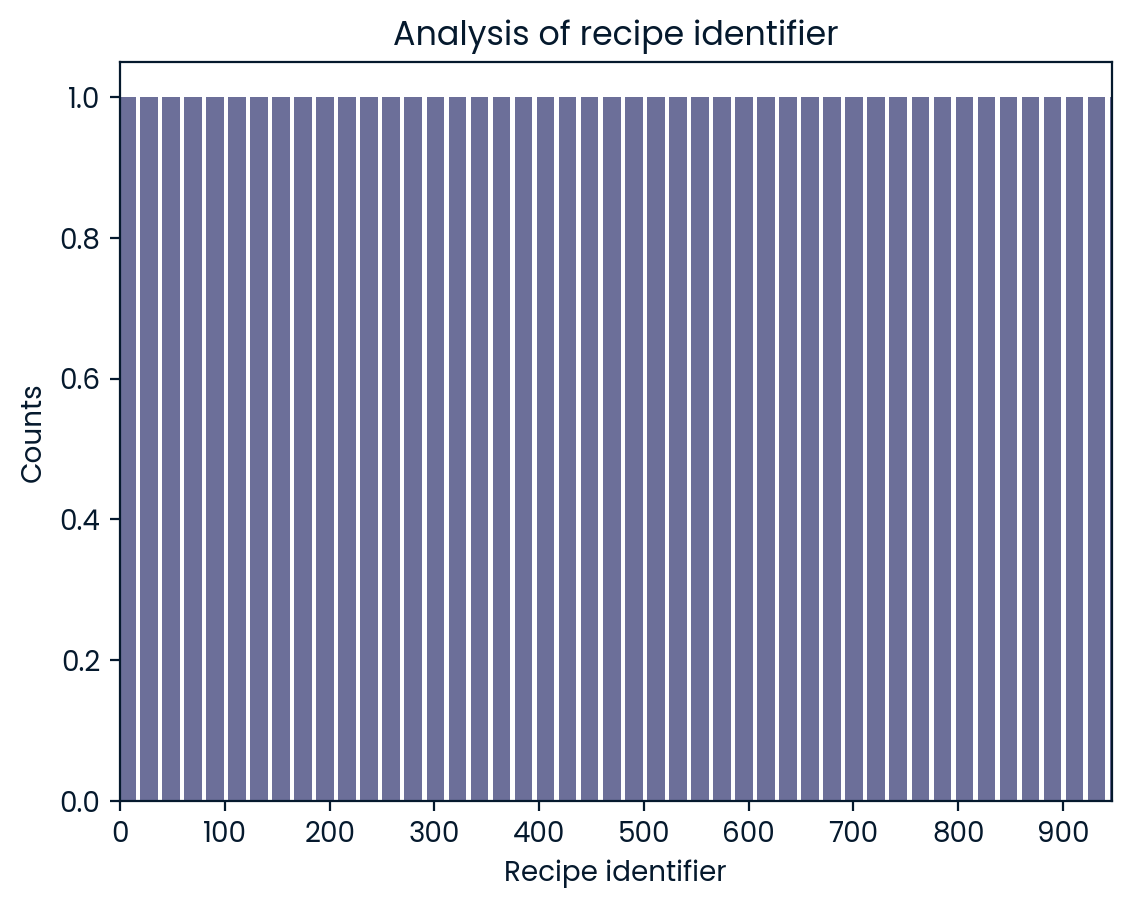

In [4]:
# exploring "recipe" column:
fig, ax = plt.subplots()
sns.countplot(data=data, x="recipe",ax=ax)
ax.set_xticks([0,100,200,300,400,500,600,700,800,900], [0,100,200,300,400,500,600,700,800,900])
#data["recipe"].hist(bins=range(data["recipe"].max()), ax=ax)
ax.set_xlabel("Recipe identifier")
ax.set_ylabel("Counts")
ax.set_title("Analysis of recipe identifier")
plt.show()

As this plot confirms my assumption, the "recipe" column is no longer of interest for the remainder of this analysis. Thus I will ignore it from now on.

Next I check the category column:

In [5]:
# Print info about category column
print("Number of categories:", data["category"].nunique())
print("Categories:", data["category"].unique())

Number of categories: 11
Categories: ['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']


I observe an extra category "Chicken Breast". This is a data issue.

Next I look at the value ranges of the four continuous data columns "calories", "carbohydrate", "sugar" and "protein":

In [6]:
# Validating data ranges for continuous variables
data[["calories", "carbohydrate", "sugar", "protein"]].describe()

,calories,carbohydrate,sugar,protein
count,895.000000,895.000000,895.000000,895.000000
mean,435.939196,35.069676,9.046547,24.149296
std,453.020997,43.949032,14.679176,36.369739
min,0.140000,0.030000,0.010000,0.000000
25%,110.430000,8.375000,1.690000,3.195000
50%,288.550000,21.480000,4.550000,10.800000
75%,597.650000,44.965000,9.800000,30.200000
max,3633.160000,530.420000,148.750000,363.360000


In [7]:
# Inspecting recipe with maximal calories value
data.iloc[data["calories"].argmax()]

recipe              926
calories        3633.16
carbohydrate      29.07
sugar              0.35
protein            2.32
category        Chicken
servings              4
high_traffic        NaN
Name: 925, dtype: object

The minimal and maximal values for these four columns are all plausible. However, it is impossible to identify if they are self-consistent, i.e. given the available information it is impossible to validate if there is an issue regarding the actual numbers in the columns "calories", "carbohydrate", "sugar" and "protein". While obviously "calories" scale proportionally to the three given macronutrients, the macronutrient "fat" is missing in the list

For example, the maximum value of "calories" is 3633.16 associated with a chicken-based recipe having 29.07g of carbohydrates, 0.35g of sugar and 2.32g of protein. At first this high number of calories seems excessive but there is no information about other nutrients such as fat. Hence there is no way to tell if there is actually a problem with this data point or not. In a real-world case this would require me to go back to the data source and request clarification. In the context of this exam I have no choice but to assume the values in those four columns are correct and self-consistent.


**The initial data analysis shows the following:**

1. There are now issues in the "recipe" column. No values are missing and the data type is as described by the product manager.
2. The "category" column contains 11 categories instead of 10 as claimed by the product manager: "Chicken Breast" shows up as an additional column. Further, this column should be converted into a categorical column.
3. The column "servings" should be numeric but is given as a sting (this may hint at a deeper issue). 
4. Some data in the following columns is missing

- calories
- carbohydrate
- sugar
- protein
- high_traffic

Items 2 - 4 are data problems which I will correct first.

### 1.1) Cleaning the "category" column (removing "Chicken Breast" and converting to categorical)

It is reasonable to simply map "Chicken Breast" to "Chicken".

In [8]:
# Map "Chicken Breast" to "Chicken"
data.loc[data["category"] == "Chicken Breast", "category"] = "Chicken"

# Explicitly make "category" column categorical
data["category"] = data["category"].astype("category")

In [9]:
# Check results
print("Categories:", data["category"].unique())

data["category"].describe()

Categories: ['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal', 'Chicken', 'Lunch/Snacks', 'Vegetable', 'Meat', 'Dessert']
Categories (10, object): ['Beverages', 'Breakfast', 'Chicken', 'Dessert', ..., 'One Dish Meal', 'Pork', 'Potato', 'Vegetable']


count         947
unique         10
top       Chicken
freq          172
Name: category, dtype: object

At this point the issues in the "category" column are fixed. 

### 1.2) Correcting data type of "servings" column

In [10]:
# Check values in servings column
data["servings"].unique()

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

Looking at the original values in the columns "servings" shows that those values were loaded as strings because the columns contains values such as "4 as a snack" and "6 as a snack". As this column is supposed to be of a numeric type (i.e. integer) per instructions of the product manager, I shall first map the values "4 as a snack" to "4" and "6 as a snack" to "6", respectively. Subsequently, I will convert all the number characters to actual integer values.

In [11]:
# Map incorrect values to correct ones
data.loc[data["servings"]=="4 as a snack", "servings"] = "4"
data.loc[data["servings"]=="6 as a snack", "servings"] = "6"

# Cast to integers
data["servings"] = data["servings"].astype(int)

In [12]:
# Check results
print("Data type of 'servings' column:", data["servings"].dtype)
data["servings"].value_counts(dropna=False)


Data type of 'servings' column: int64


4    391
6    198
2    183
1    175
Name: servings, dtype: int64

At this point the issues in the "servings" column are fixed.

### 1.3) Treatment of missing data

First I check how many rows contain missing values for each of the columns:

In [13]:
# Count missing values per column
data.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

The columns "calories", "carbohydrate", "sugar" and "protein" miss 52 values each. 52 rows out of the total number of 947 rows in the data set corresponds to 5.4% of the data. This exceeds the 5%, which are usually considered the maximum amount of rows one should simply remove from a data set in order to not reduce the data set size too much.

As there are 373 missing values in the high_traffic column (almost 40% of the entire data set), they cannot be removed either.

It follows that the missing data needs to be imputed.

#### 1.3.1) Imputation of calories, carbohydrate, sugar and protein

I want to impute the missing calories, carbohydrate, sugar and protein values by using an aggregate value over "category" groups. In order to identify if it is best to use the mean or the median as an aggregate value, I check if those four columns contain outliers. If that is the case, I shall use the median instead of the mean value.

In [14]:
data[["calories", "carbohydrate", "sugar", "protein"]].describe()

,calories,carbohydrate,sugar,protein
count,895.000000,895.000000,895.000000,895.000000
mean,435.939196,35.069676,9.046547,24.149296
std,453.020997,43.949032,14.679176,36.369739
min,0.140000,0.030000,0.010000,0.000000
25%,110.430000,8.375000,1.690000,3.195000
50%,288.550000,21.480000,4.550000,10.800000
75%,597.650000,44.965000,9.800000,30.200000
max,3633.160000,530.420000,148.750000,363.360000


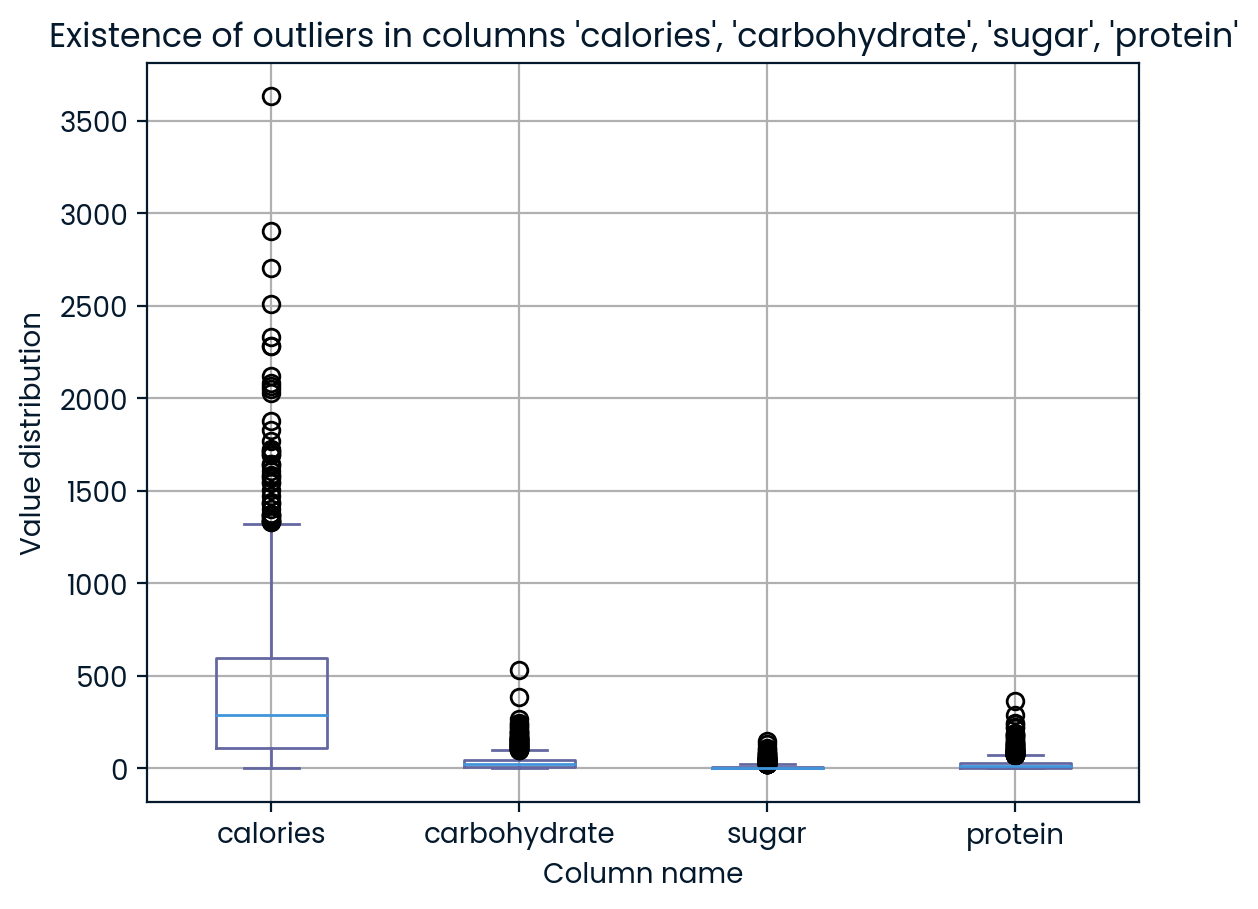

In [15]:
fig, ax = plt.subplots()
data[["calories", "carbohydrate", "sugar", "protein"]].plot.box(ax = ax, grid=True)
ax.set_title("Existence of outliers in columns 'calories', 'carbohydrate', 'sugar', 'protein'")
ax.set_xlabel("Column name")
ax.set_ylabel("Value distribution")
plt.show()

Obviously, outliers do exist in those four columns and hence I impute the missing values using the median of the values in those columns (grouped by the category column).

In [16]:
# Compute group-wise median for each of the four columns of interest
medians = dict()
for col in ["calories", "carbohydrate", "sugar", "protein"]:
    medians[col] = data[[col, "category"]].groupby("category").median().to_dict()[col]
    
# Replace missing values in these four columns with the group-wise medians computed before
for col in ["calories", "carbohydrate", "sugar", "protein"]:
    n_replaced = 0
    for cat in data["category"].unique():
        # Filter out relevant rows from "data" 
        colcat_filter = (data["category"]==cat) & (data[col].isna())
        n_replaced += sum(colcat_filter)
        if sum(colcat_filter)>0:
            data.loc[colcat_filter, col] = medians[col][cat]
    
    assert n_replaced == 52 # sanity check

In [17]:
# Check results
print("Checking that there are no more missing values in the columns 'calories', 'carbohydrate', 'sugar' and 'protein':")
data[["calories", "carbohydrate", "sugar", "protein"]].isna().sum().to_frame().rename({0: "number of missing values"}, axis=1)

Checking that there are no more missing values in the columns 'calories', 'carbohydrate', 'sugar' and 'protein':


,number of missing values
calories,0
carbohydrate,0
sugar,0
protein,0


At this point the issues in the "calories", "carbohydrate", "sugar" and "protein" columns are resolved.

#### 1.3.2) Imputation of high_traffic column

In [18]:
# Get set of values in the "high_traffic" column
data["high_traffic"].unique()

array(['High', nan], dtype=object)

Next, I analyze the "high_traffic" column. Printing a list of values in this column shows that there are only two values: "High" and nan (the latter being the missing values). This suggests that only those recipes/rows were given a non-null value "High" that lead to high traffic. The other recipes/rows were not labelled at all. Hence, it is reasonable to simply give all those non-labelled rows a real label, which I will call "Low".

In [19]:
# Map all null values to the string value "Low"
data.loc[data["high_traffic"].isna(), "high_traffic"] = "Low"

In [20]:
# Check result
data["high_traffic"].unique()

array(['High', 'Low'], dtype=object)

At this point the missing data issue in the "high_traffic" column has also been resolved.

### 1.4) Adjust numerical precision where necessary

In a last data cleaning step I adjust the precision with which the numbers in the "calories", "carbohydrate", "sugar" and "protein" columns are given. It is reasonable to assume that tens of grams are more than enough precision, i.e. I round the values in these columns to one decimal place.

In [21]:
# Adjust numerical precision
data["calories"] = data["calories"].round(1)
data["carbohydrate"] = data["carbohydrate"].round(1)
data["sugar"] = data["sugar"].round(1)
data["protein"] = data["protein"].round(1)

# Check results
data.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,399.3,19.6,5.2,29.8,Pork,6,High
1,2,35.5,38.6,0.7,0.9,Potato,4,High
2,3,914.3,42.7,3.1,2.9,Breakfast,1,Low
3,4,97.0,30.6,38.6,0.0,Beverages,4,High
4,5,27.0,1.8,0.8,0.5,Beverages,4,Low


The numerical precision is now at a reasonable level for all numeric columns.

### 1.5) Adding numerical/binary "high_traffic" column for convenience

As the "high_traffic" column will play to role of the dependent variable in a binary classification task later on, it will be convenient to have these labels in binary representation. Therefore I am going to add an auxiliary column "binary_high_traffic" to the data set where the value "High" in the "high_traffic" column will be mapped to 1 in the "binary_high_traffic" column and "Low" will be mapped to 0.

In [22]:
# Creating auxiliary column "binary_high_traffic" containing digital labels 0 and 1
data["binary_high_traffic"] = data["high_traffic"].apply(lambda x: 1 if x == "High" else 0)

**At this point the data is fully validated and clean. Missing values have been imputed (or, in the case of the "high_traffic" column replaced), data types were corrected and value ranges were checked (as far as possible). Now, the data set adheres to the format as per the project managers description.**

Further I have adjusted the precision of numerical data where necessary and I added an auxiliary column to the data set. I provide another overview over the data set after cleaning and validation in the following two cells.

In [25]:
# Checking overall shape/format of the data after cleaning and validation - step 1
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   recipe               947 non-null    int64   
 1   calories             947 non-null    float64 
 2   carbohydrate         947 non-null    float64 
 3   sugar                947 non-null    float64 
 4   protein              947 non-null    float64 
 5   category             947 non-null    category
 6   servings             947 non-null    int64   
 7   high_traffic         947 non-null    object  
 8   binary_high_traffic  947 non-null    int64   
dtypes: category(1), float64(4), int64(3), object(1)
memory usage: 60.6+ KB


In [26]:
# Checking overall shape/format of the data after cleaning and validation - step 2
data.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,binary_high_traffic
0,1,399.3,19.6,5.2,29.8,Pork,6,High,1
1,2,35.5,38.6,0.7,0.9,Potato,4,High,1
2,3,914.3,42.7,3.1,2.9,Breakfast,1,Low,0
3,4,97.0,30.6,38.6,0.0,Beverages,4,High,1
4,5,27.0,1.8,0.8,0.5,Beverages,4,Low,0


## 2) Data Visualization

In order to get to know the data better I will create a few graphical representations. 

### 2.1) Transforming distributions of "calories", "carbohydrate", "protein" and "sugar" to gaussians
I have already shown the box plots for the four columns "calories", "carbohydrate", "protein" and "sugar" above. There it was demonstrated that the respective distributions are skewed. In light of the fact that I will conduct a correlation analysis between these variables in subsection 2.3, it makes sense to transform these columns such that they become more gaussian. Otherwise, in the pair-wise scatter plots in section 2.3 all points would be clustered in the lower left corner of the plot panels making it really hard to identify potential correlations.

This the mapping between the original and transformed variables is visualized next.

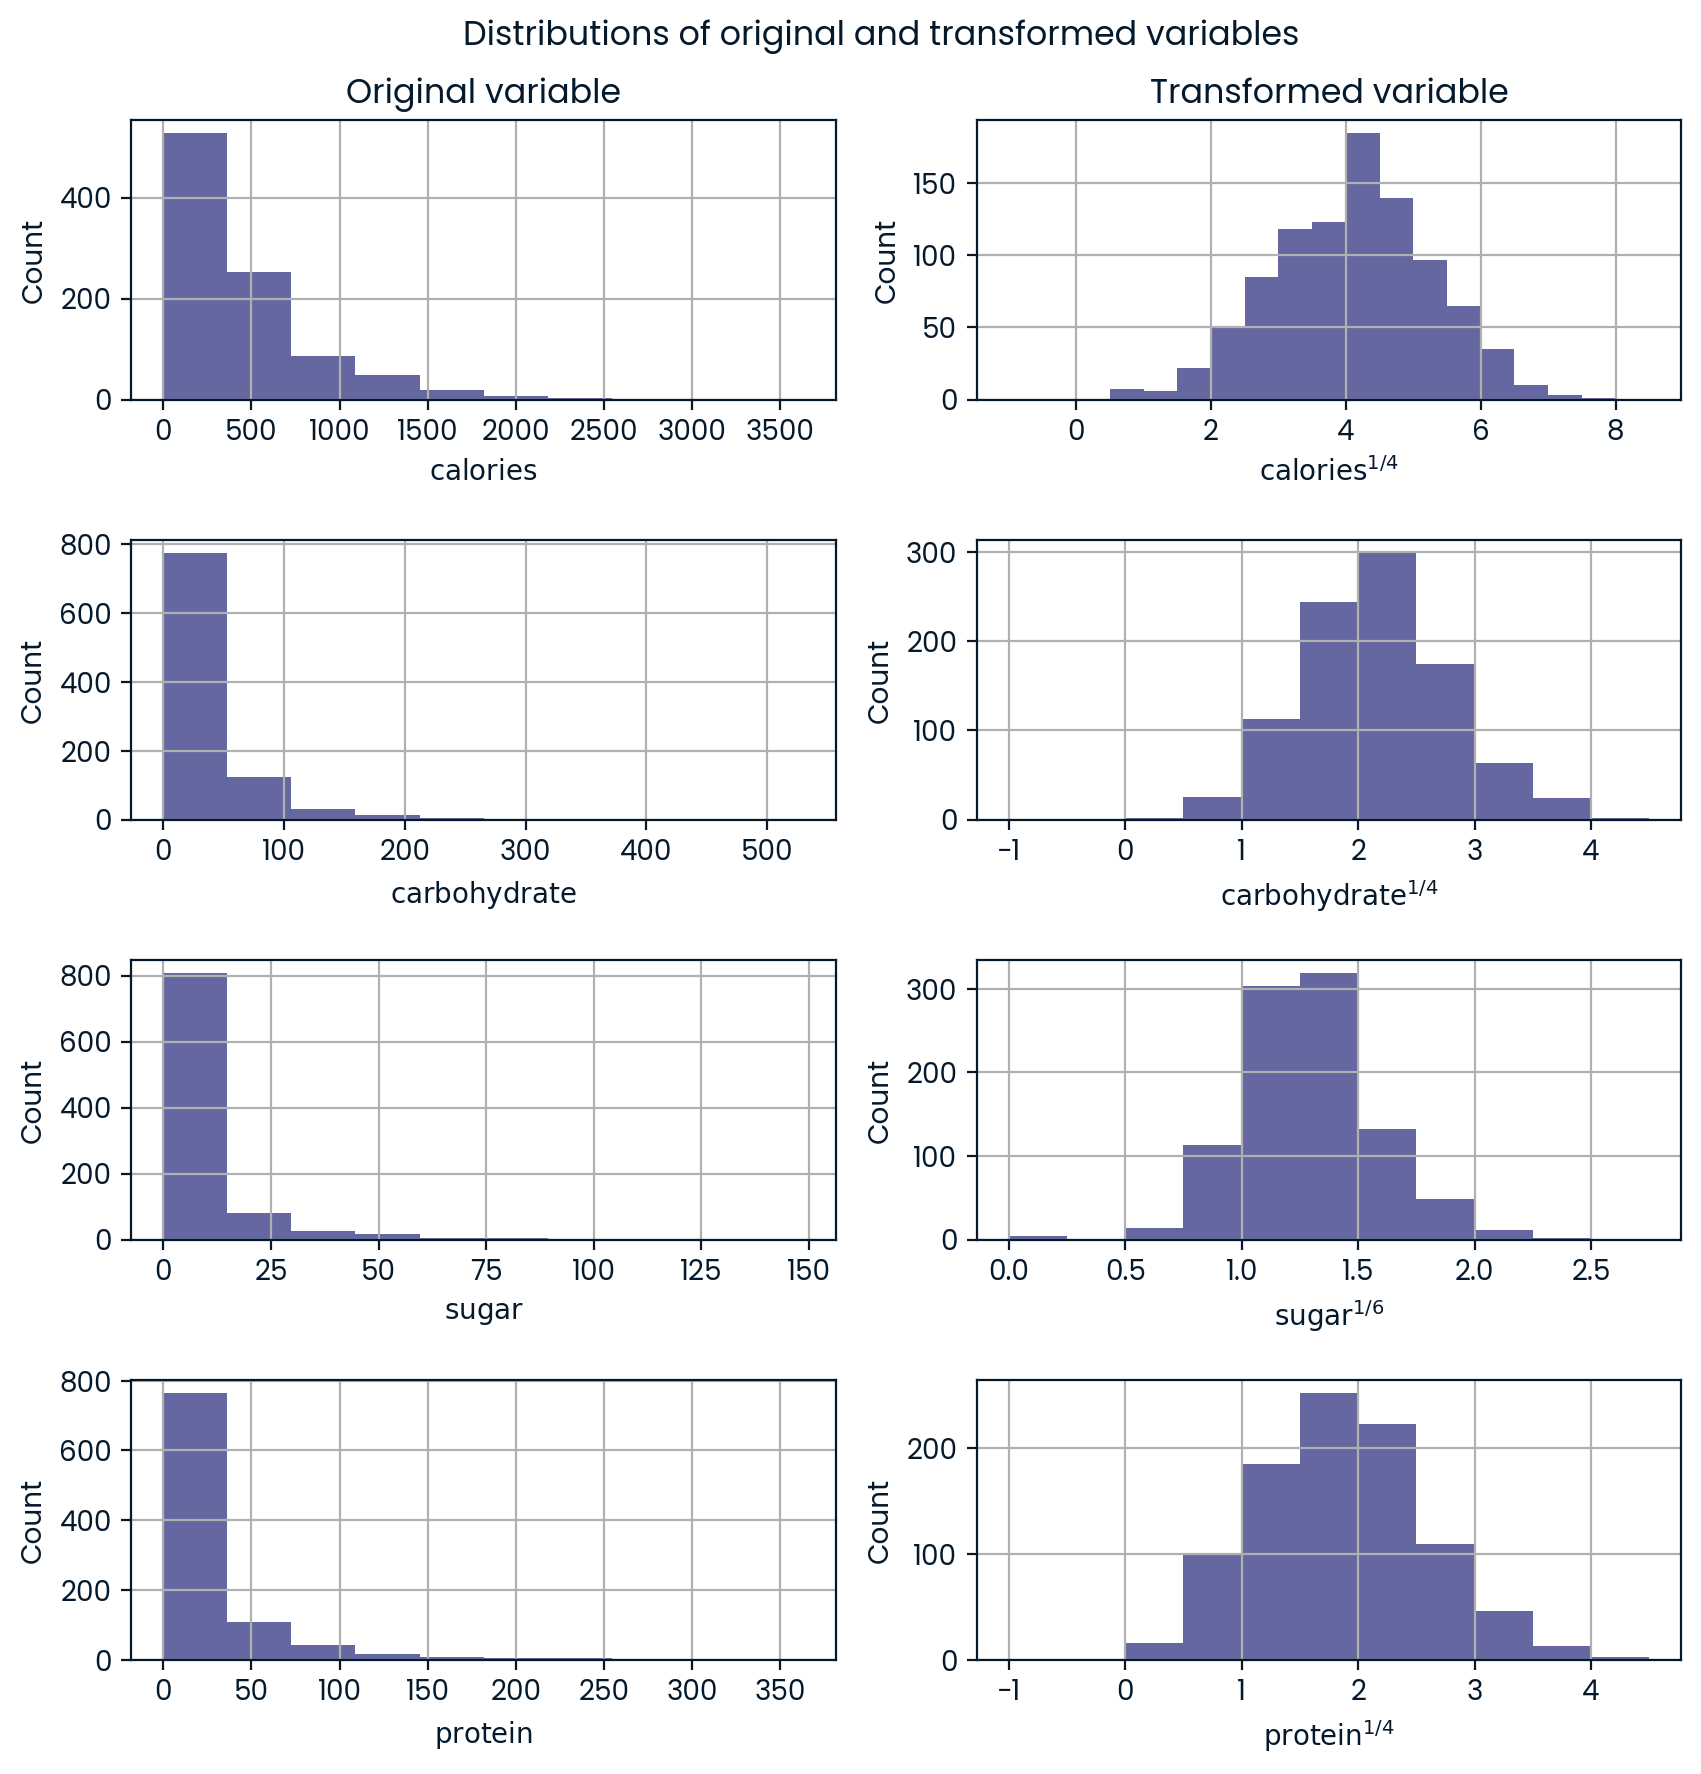

In [27]:
# Graphical inspection of transformations that turn the distributions of "calories", "carbohydrate", "protein" and "sugar" to gaussians

fig, axs = plt.subplots(4,2, figsize=(10,10), gridspec_kw={"hspace": 0.5})

# calories --> calories^(1/4)
axs[0,0].hist(data["calories"])
axs[0,0].grid(True)
axs[0,0].set_xlabel(r"$\mathrm{calories}$")
axs[0,0].set_ylabel("Count")
axs[0,0].set_title("Original variable")
axs[0,1].hist(data["calories"].apply(lambda x: x**(1/4)), bins=np.arange(-1,9,0.5))
axs[0,1].grid(True)
axs[0,1].set_xlabel(r"$\mathrm{calories}^{1/4}$")
axs[0,1].set_ylabel("Count")
axs[0,1].set_title("Transformed variable")

# carbohydrate --> carbohydrate^(1/4)
axs[1,0].hist(data["carbohydrate"])
axs[1,0].grid(True)
axs[1,0].set_xlabel("$\mathrm{carbohydrate}$")
axs[1,0].set_ylabel("Count")
axs[1,1].hist(data["carbohydrate"].apply(lambda x: x**(1/4)), bins=np.arange(-1,5,0.5))
axs[1,1].grid(True)
axs[1,1].set_xlabel(r"$\mathrm{carbohydrate}^{1/4}$")
axs[1,1].set_ylabel("Count")

# sugar --> sugar^(1/6)
axs[2,0].hist(data["sugar"])
axs[2,0].grid(True)
axs[2,0].set_xlabel("$\mathrm{sugar}$")
axs[2,0].set_ylabel("Count")
axs[2,1].hist(data["sugar"].apply(lambda x: x**(1/6)), bins=np.arange(0,3,0.25))
axs[2,1].grid(True)
axs[2,1].set_xlabel(r"$\mathrm{sugar}^{1/6}$")
axs[2,1].set_ylabel("Count")

# protein --> protein^(1/4)
axs[3,0].hist(data["protein"])
axs[3,0].grid(True)
axs[3,0].set_xlabel("$\mathrm{protein}$")
axs[3,0].set_ylabel("Count")
axs[3,1].hist(data["protein"].apply(lambda x: x**(1/4)), bins=np.arange(-1,5,0.5))
axs[3,1].grid(True)
axs[3,1].set_xlabel(r"$\mathrm{protein}^{1/4}$")
axs[3,1].set_ylabel("Count")

fig.suptitle("Distributions of original and transformed variables", y=0.93)
plt.show()

The above set of histograms shows that the distributions of the fourth roots of "calories", "carbohydrate" and "protein" as well as the sixth root of "sugar" approximate normal distributions. Therefore I add these transformed variables to the data set.

In [28]:
# Create new columns with transformed variables
data["calories_fourth_root"] = data["calories"].apply(lambda x: x**(1/4))
data["carbohydrate_fourth_root"] = data["carbohydrate"].apply(lambda x: x**(1/4))
data["sugar_sixth_root"] = data["sugar"].apply(lambda x: x**(1/6))
data["protein_fourth_root"] = data["protein"].apply(lambda x: x**(1/4))

### 2.2) Analysis of value imbalance in discrete-valued columns

In order to identify potential imballances in the data columns I shall explore the distributions of values in the "servings", the "category" and the "high_traffic" column in a next step. The graphics below show that the largest fraction of recipes in the data set at hand amount to four (4) servings, most are with chicken and there are considerably more recipes in the data set that lead to high web page traffic than recipes that lead to low traffic.

This knowledge is important as any machine learning model created later on will thus must likely be most accurate for recipes with chicken and those that amount to four servings.

Moreover, the fact that we have more high web page traffic-generating recipes than recipes generating low traffic means that the data set is imbalanced. This needs to be accounted for when building the machine learning model and in particular during its validation. Ignoring this fact can lead to an overly optimistic interpretation of the model validation metrics.

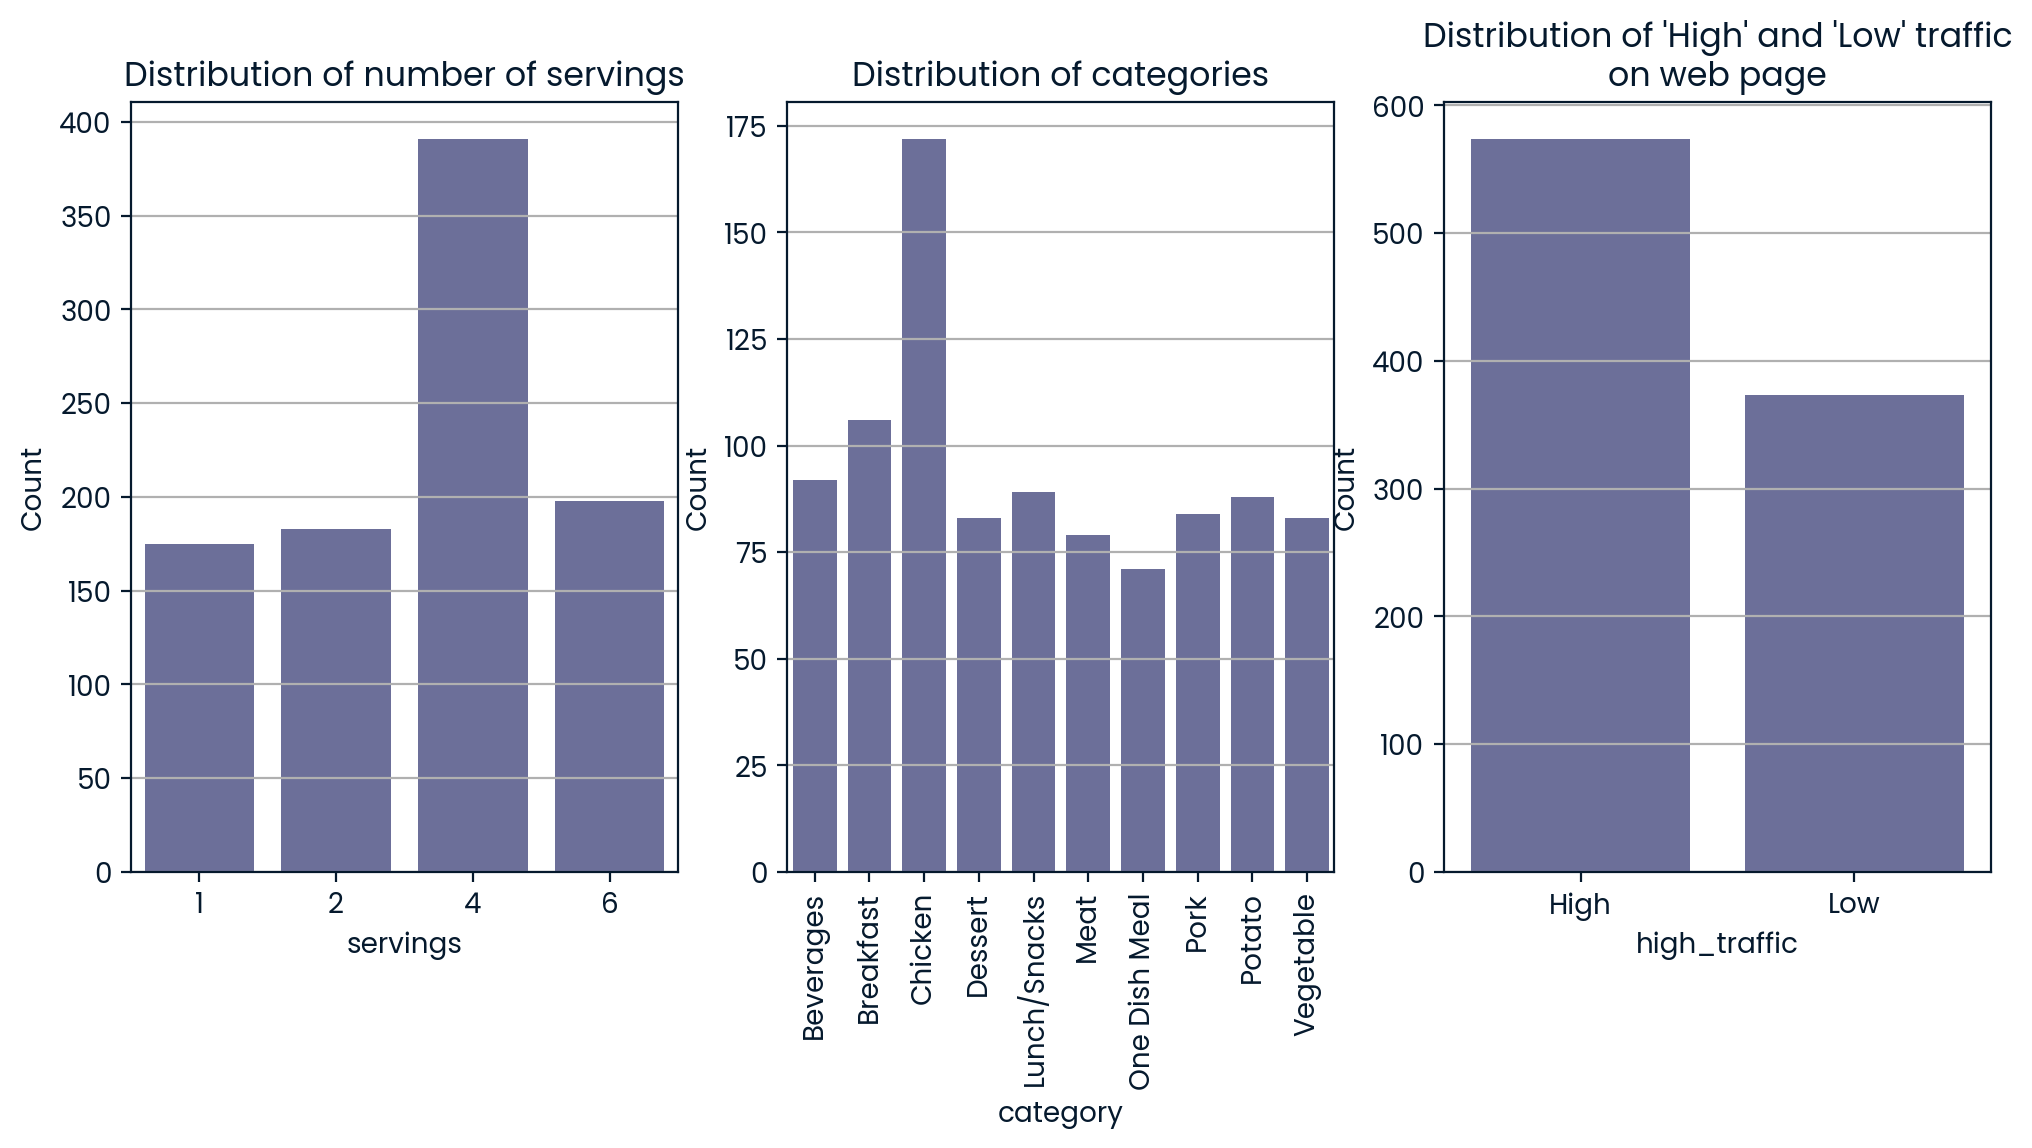

In [29]:
# Imbalance plots
fig, axs = plt.subplots(1,3, figsize=(12,5))
ax = axs[0] 
ax.grid(True)
sns.countplot(data=data, x="servings", ax=ax)
ax.set_title("Distribution of number of servings")
ax.set_ylabel("Count")

ax = axs[1] 
ax.grid(True)
sns.countplot(data=data.sort_values("category"), x="category", ax=ax)
ax.set_title("Distribution of categories")
ax.set_xticklabels(data.sort_values("category")["category"].unique(), rotation=90)
ax.set_ylabel("Count")

ax = axs[2] 
ax.grid(True)
sns.countplot(data=data, x="high_traffic", ax=ax)
ax.set_title("Distribution of 'High' and 'Low' traffic\non web page")
ax.set_ylabel("Count")
plt.show()

### 2.3) Correlations between variables

#### 2.3.1) Correlations between independent variables (features)
In order for the classifier to work correctly, one needs to make sure that the independent variables are not correlated with each other. To analyze this I look at the pairwise scatter plots between the variables. Notice that in order to get a better view of the data I work with the transformed variables (using the raw variables leads to the situation where most points in the scatter plots are clustered in the lower left corner).

Text(0.5, 1.02, 'Correlation analysis')

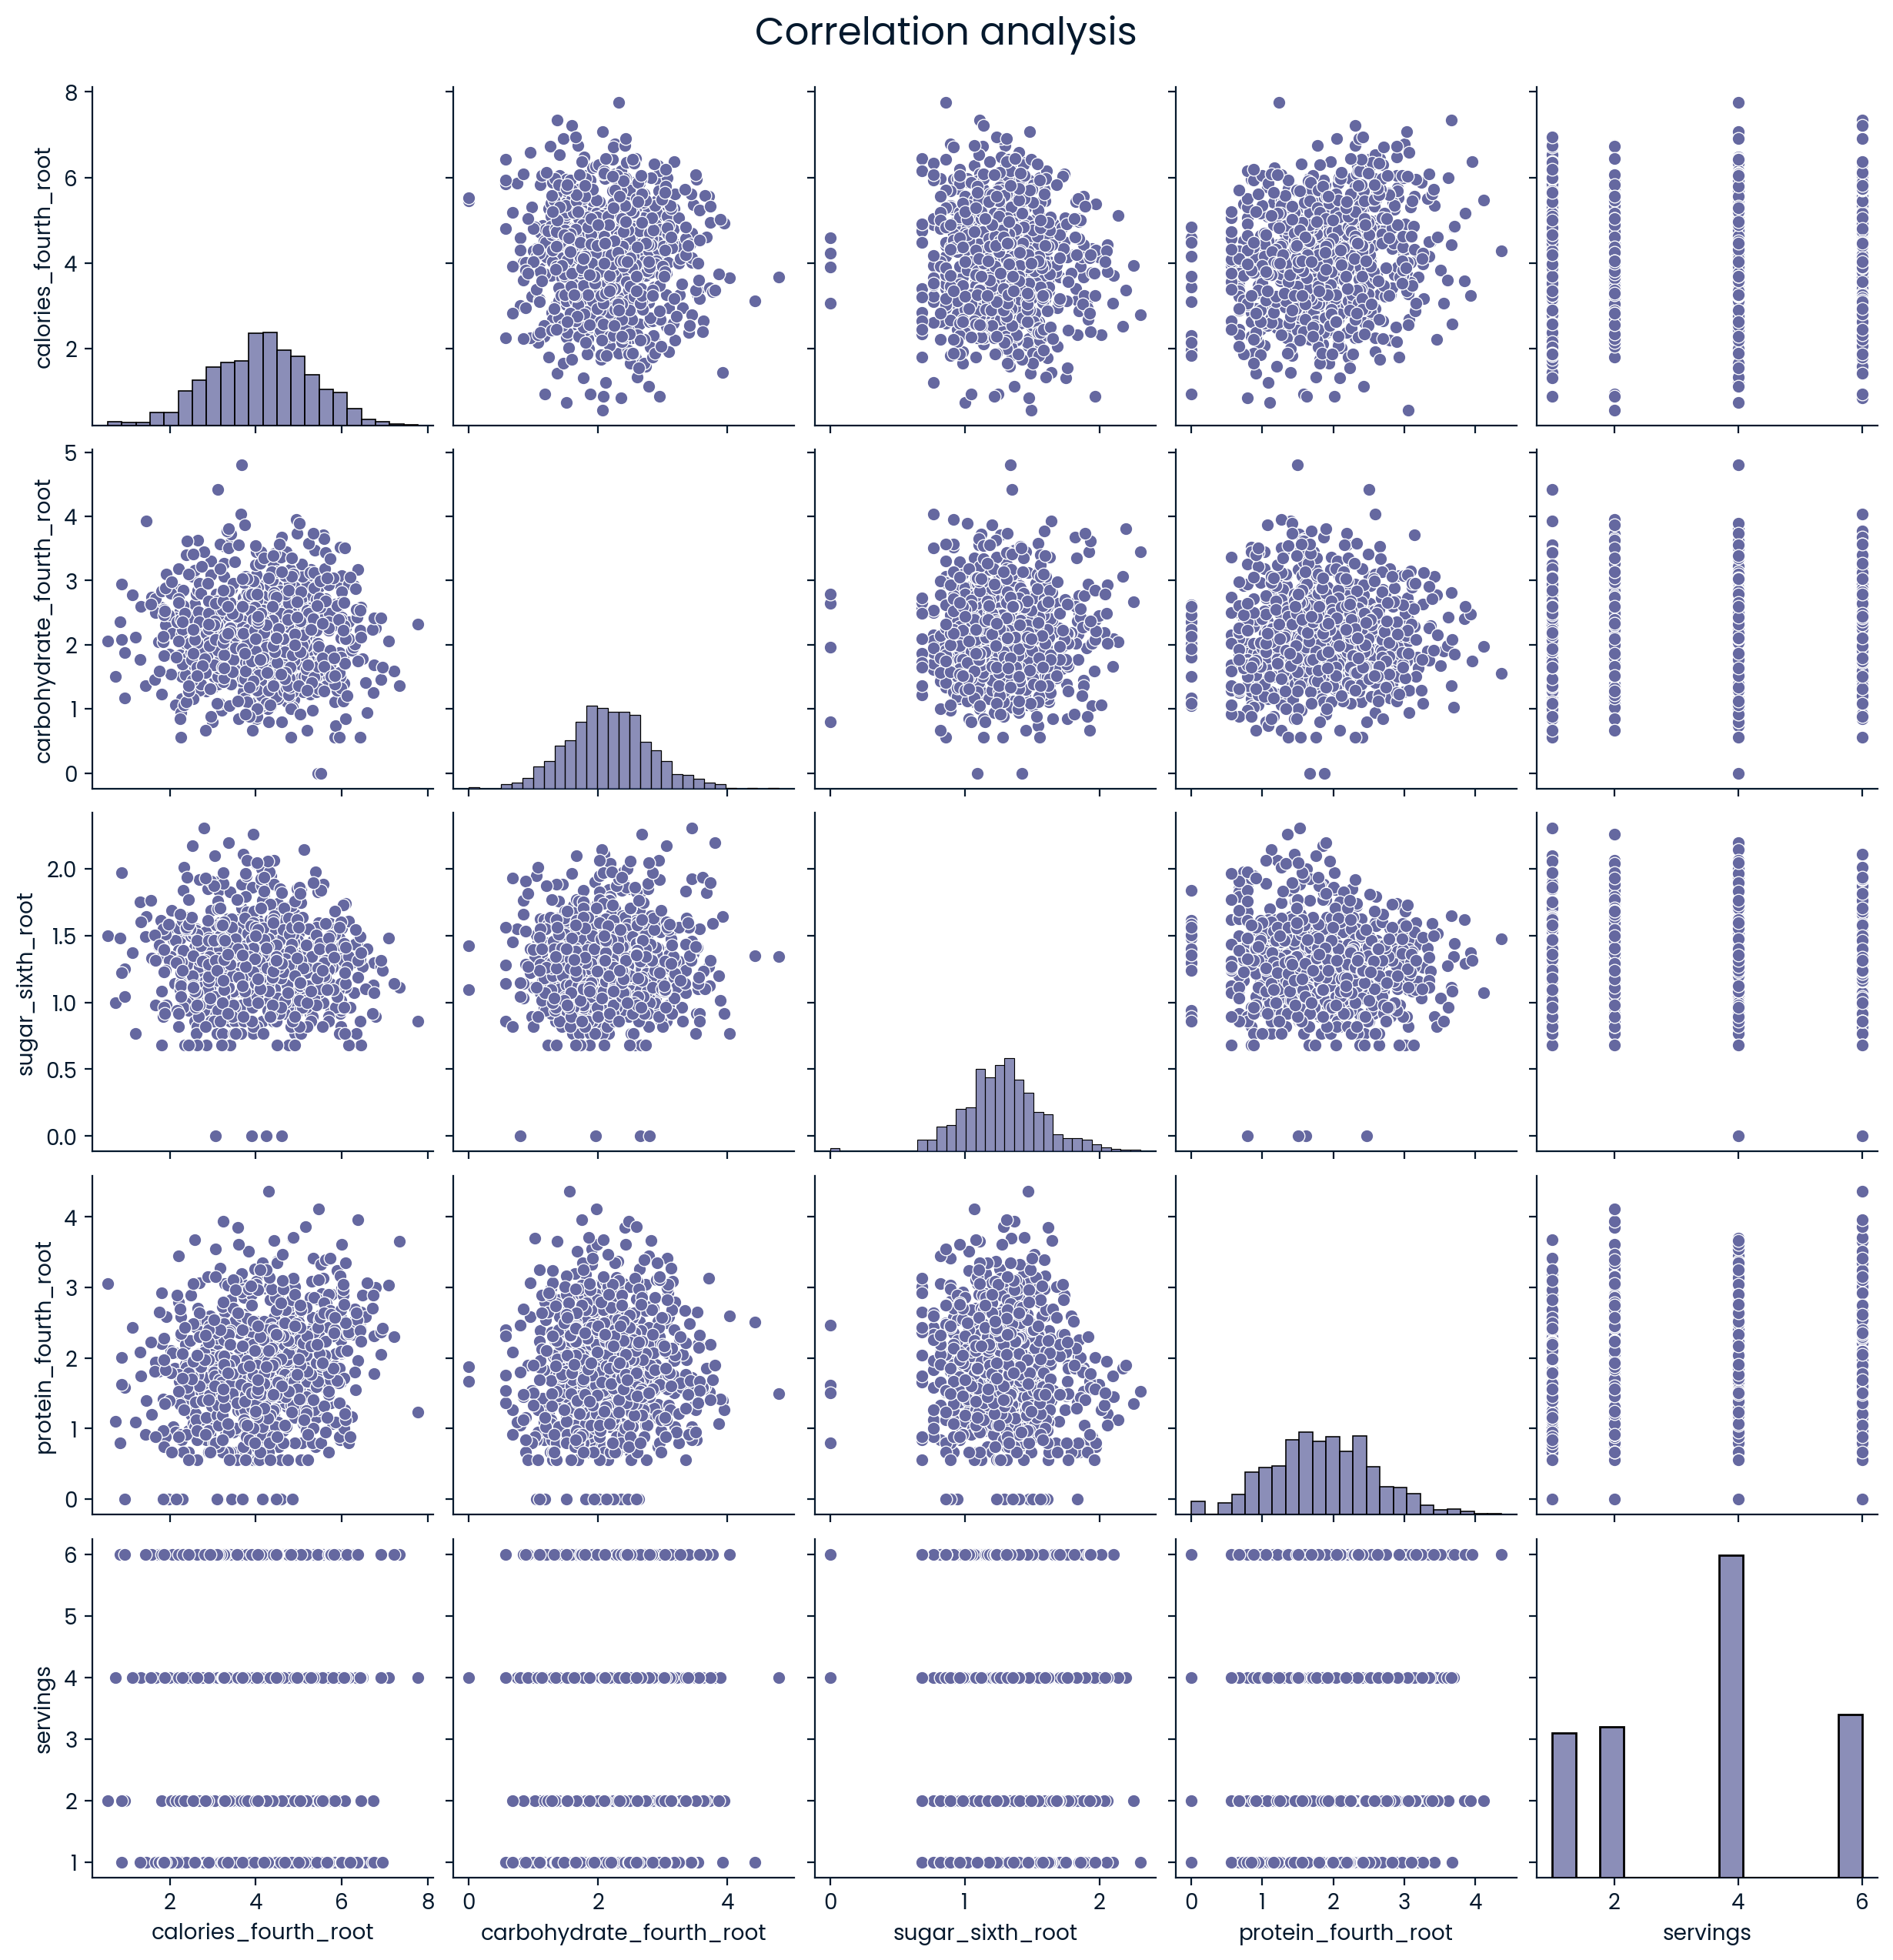

In [30]:
g = sns.pairplot(data[["calories_fourth_root", 
                   "carbohydrate_fourth_root", 
                   "sugar_sixth_root", 
                   "protein_fourth_root", 
                   "servings"]])
g.fig.suptitle("Correlation analysis", y=1.02, fontsize=18)

These scatter plots do not exhibit any signs of correlation between the independent variables.

#### 2.3.2) Impact of calories, macronutrients, number of servings and recipe category on web page traffic

I check if it is possible to identify any correlation between the traffic on the web page and

(a) the amount calories, 

(b) the amount of any given macronutrient (i.e. carbohydrate, sugar and protein)

(c) the number of servings per recipe and

(d) the recipe category.

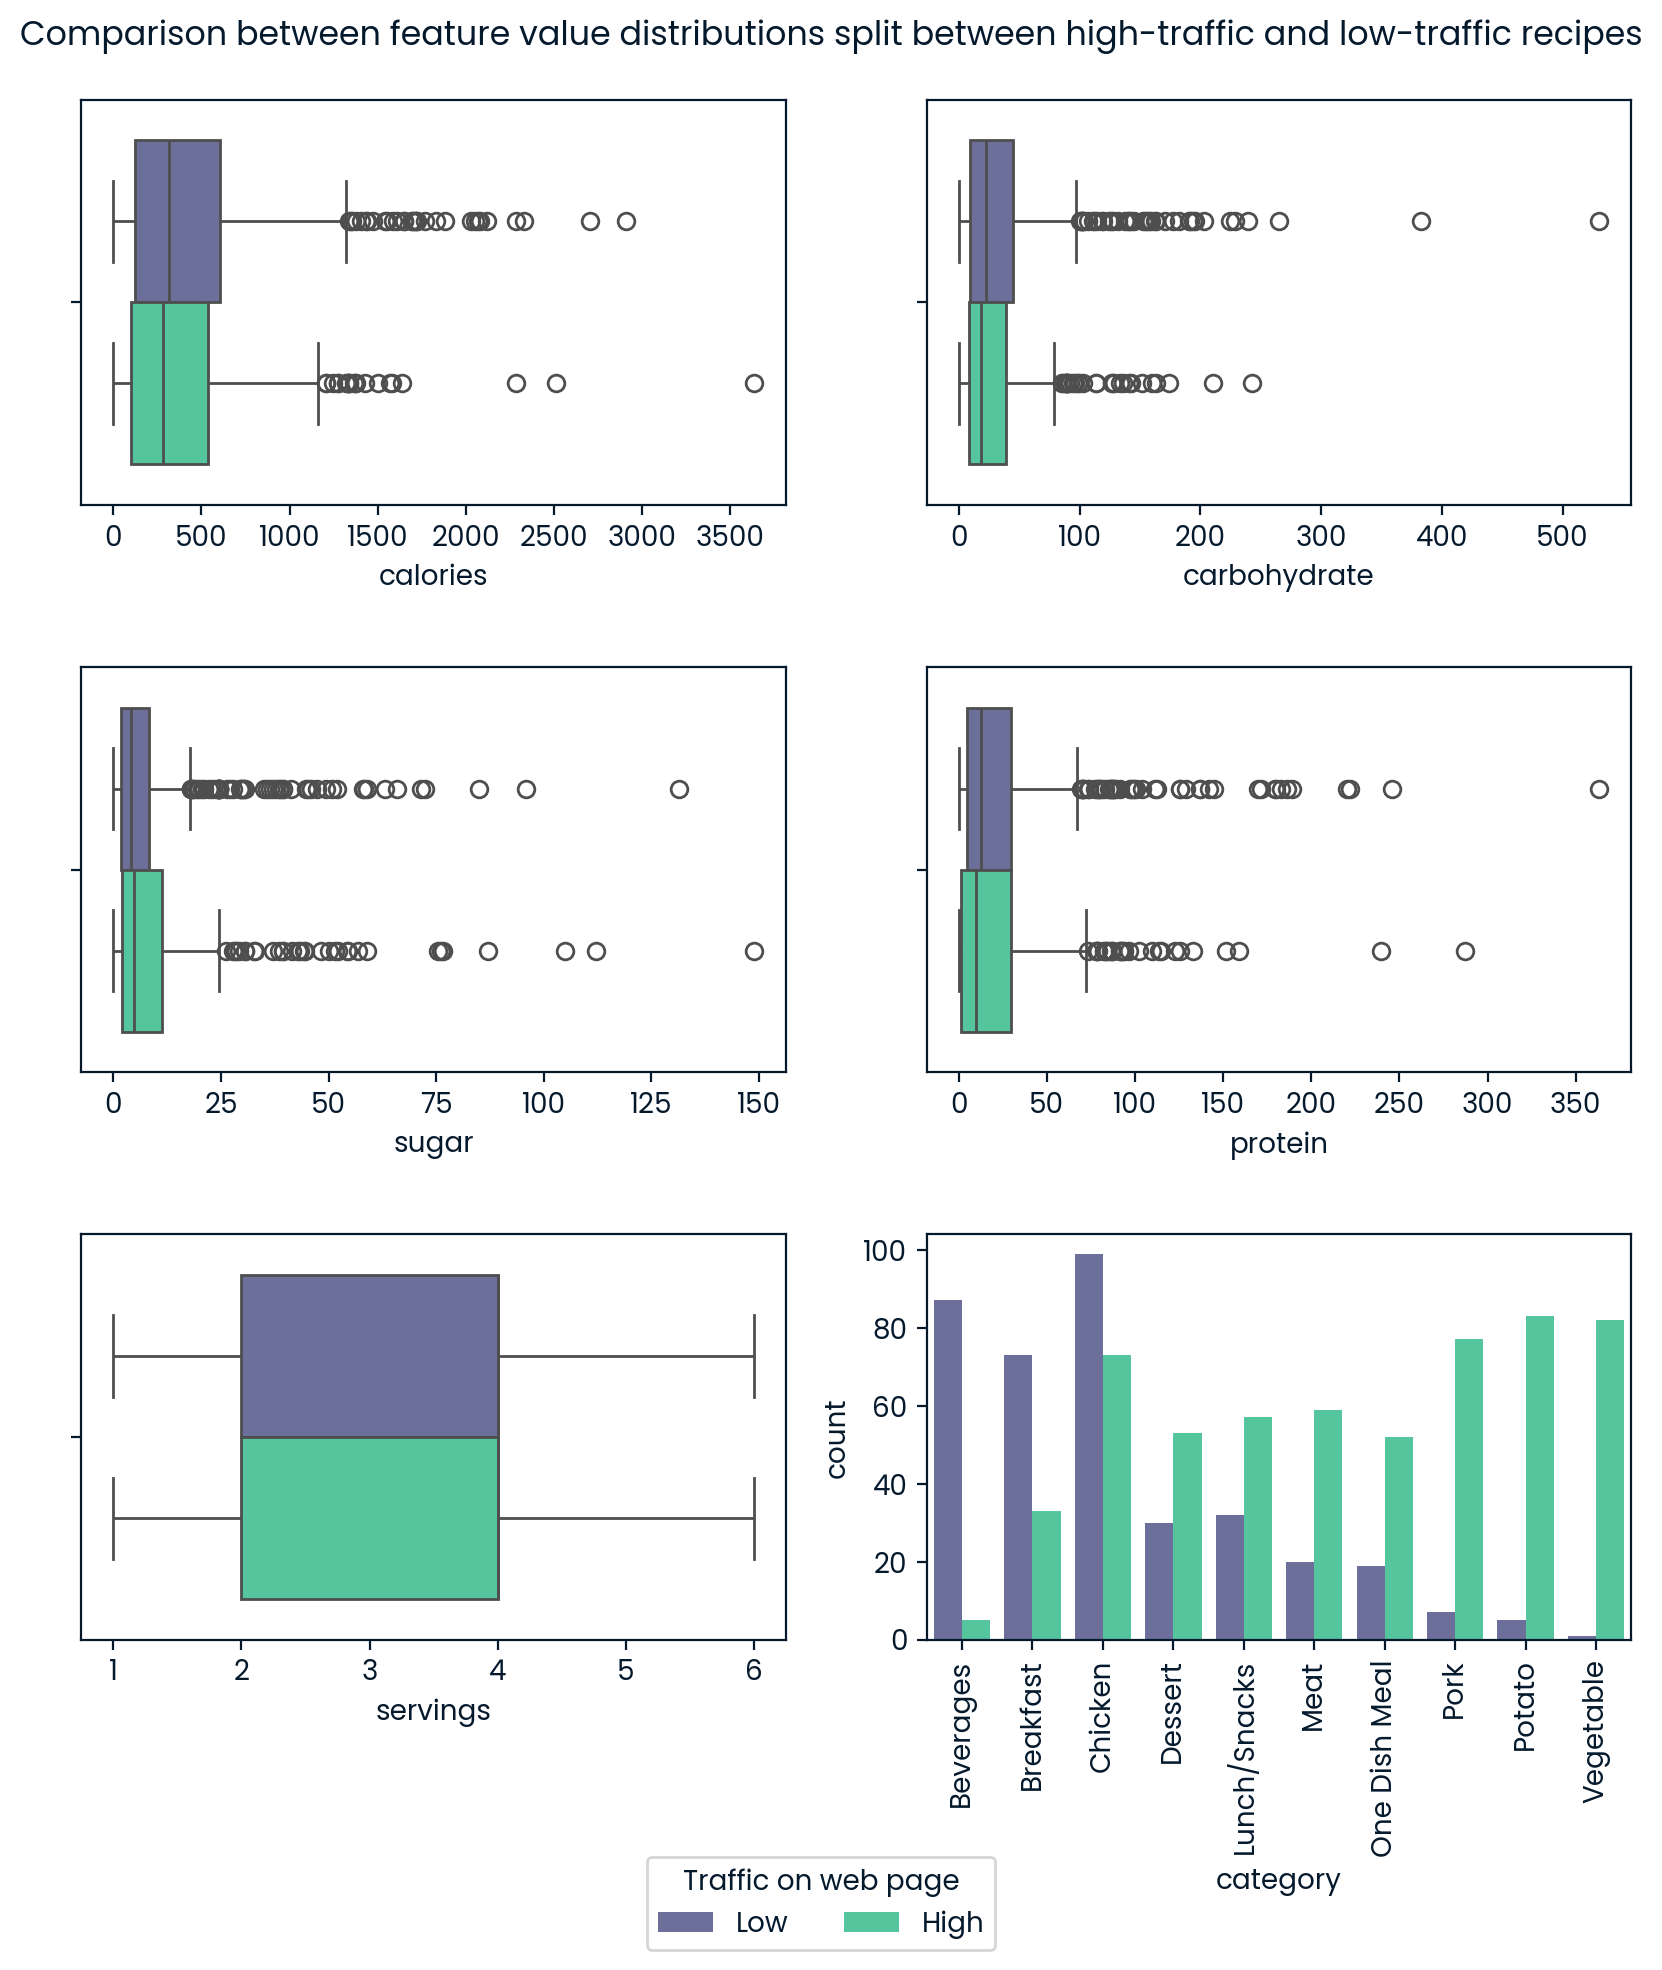

In [31]:
# Box plots for each feature variable split by high- and low-traffic recipes
fig, axs = plt.subplots(3,2, figsize=(10,10), gridspec_kw={"hspace":0.4})
sns.boxplot(data=data, x="calories", hue="high_traffic", ax=axs[0,0], legend=False)
sns.boxplot(data=data, x="carbohydrate", hue="high_traffic", ax=axs[0,1], legend=False)
sns.boxplot(data=data, x="sugar", hue="high_traffic", ax=axs[1,0], legend=False)
sns.boxplot(data=data, x="protein", hue="high_traffic", ax=axs[1,1], legend=False)
sns.boxplot(data=data, x="servings", hue="high_traffic", ax=axs[2,0], legend=False)
sns.countplot(data=data.sort_values("category"), x="category", hue="high_traffic", ax=axs[2,1])
axs[2,1].set_xticklabels(data.sort_values("category")["category"].unique(), rotation=90)
axs[2,1].legend(loc="lower center", bbox_to_anchor=(-0.15,-0.8), ncol=2, title="Traffic on web page")
fig.suptitle("Comparison between feature value distributions split between high-traffic and low-traffic recipes", y=0.92)
plt.show()

The following conclusions can be drawn from these graphics: The amount of calories and macronutrients is quite similar for both the recipes that lead to low web page traffic and those that lead to high web page traffic. The number of servings per recipe has no impact on the web page traffic whatsoever which is not unexpected (as each consumer/customer can easily scale this number according to their preferences). Last but not least it can be observed that recipes for beverages tend to lead to low traffic on the web page where recipes with pork, potato and vegetable tend to lead to high web page traffic.

## 3) Building a classifier

I am supposed to create a model which is able to classify whether a recipe (characterized by the features given in the data set, i.e. calories, carbohydrate, sugar, protein, category and servings) will generate high or low traffic on the "Tasty Bytes" web page. This is a binary classification task. The goals are to predict which recipes will lead to high traffic and correctly predict high traffic recipes 80% of the time (i.e. achieving a true positive rate of at least 80%).

The KPI of interest thus is the fraction of correctly predicted high traffic recipes, or put more explicitly, the number of correctly predicted high traffic recipes out of all recipes predicted to cause high traffic (the corresponding mathematical metric is the "precision" of the classifier). From a business perspective it makes sense to look at this metric as "Tasty Bytes" tries to  avoid displaying unpopular recipes since this would have a negative impact on the subscriptions and thus the revenue of the company. On the other hand, the impact of incorrectly classifying some popular recipes as unpopular (i.e. missing some popular recipes) is limited as this merely reduces the number of popular recipes that can be displayed. As long as this remains within reasonable limits, the business impact of this would likely be minimal. For this reason, both classifier models I am going to train will be optimized for precision.

I will choose a simple logistic regression as the baseline model. This choice is motivated by the low-dimensional hyperparameter space of the model. For comparison I will create a k-nearest neighbors (KNN) classifier which also has a low-dimensional hyperparameter space. Therefore, a randomized cross validation with similar numbers of iterations should lead to comparable results between the two approaches.

### 3.1) Preparing the data set for machine learning

A priori the features (independent variables) of this binary classifier are:

- recipe
- calories
- carbohydrate
- sugar
- protein
- category
- sevings

Right from the beginning we can exclude the "recipe" column from the list of relevant features. It is merely a numeric identifier for the recipe without any impact on its popularity (see also section 1). Further, I showed in the data visualization above (section 2) that the distirbution of the "servings" values is essentially identical between those recipes generating low and those generating high traffic. It is thus reasonable to ignore this feature, too. This leaves us with the following five features:

- calories
- carbohydrate
- sugar
- protein
- category

Four of these features are numerical (calories, carbohydrate, sugar and protein) and one (category) is categorical.The latter has to be encoded. As the "category" column represents a nominal variable with relatively low cardinality (10 categories) it can be one-hot encoded. Notice that neither logistic regression nor KNN make any assumptions about the features being distributed normally. For this reason it is perfectly fine to train the models using the original, untransformed features.

The target or dependent variable is given by the "high_traffic" column or the auxiliary but equivalent "binary_high_traffic" column.

In [32]:
# Separate features from targets
features_df = data[["calories",  
                    "carbohydrate", 
                    "sugar",
                    "protein",
                    "category"]]
labels_df = data[["binary_high_traffic"]]

#### 3.1.1) Feature encoding

As mentioned, I conduct a one-hot encoding on the categorical variable category.

In [33]:
# One-hot encode category feature
features_encoded_df = pd.get_dummies(features_df)

#### 3.1.2) Feature scaling

The next step is to scale the numerical features such that they live on similar intervals. Since I am dealing with mixed data and the one categorical features was one-hot encoded, I decide to scale all numerical features using a min-max scaler. As a result, all features (both numeric and categorical) will live on a scale [0,1].

In [34]:
# Scale all features to the interval [0,1]
scaler = MinMaxScaler()
features_scaled_array = scaler.fit_transform(features_encoded_df)
features_scaled_df = pd.DataFrame(features_scaled_array, columns = features_encoded_df.columns)

features_scaled_df.head()

,calories,carbohydrate,sugar,protein,category_Beverages,category_Breakfast,category_Chicken,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable
0,0.109879,0.036953,0.034946,0.082003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.009744,0.072775,0.004704,0.002477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.251631,0.080505,0.020833,0.007980,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.026671,0.057692,0.259409,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.007404,0.003394,0.005376,0.001376,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 3.1.3) Split data into train & test set

In order to train and validate the classifier properly, I create a train and a test set. I will use 20% of the available data for testing. It is important to stratify the data by the labels in this case as the data set is somewhat imbalanced.

In [35]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(features_scaled_df, 
                                                    labels_df, 
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    stratify=labels_df,
                                                    random_state=42)

# Check shapes of training/test features & targets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(757, 14)
(190, 14)
(757, 1)
(190, 1)


### 3.2) Logistic regression

As mentioned above, I will train a logistic regression as my baseline model. In order to get a well-performing baseline, I tune the hyperparameters using a 5-fold cross-validation approach. Just as in the train-test split, I use a stratified cross validation, which ensures that the same ratio of positive labels and negative labels is present in both the training and the validation set. I stress that the test set created earlier is not involved in the training procedure at all in order to avoid giving overly optimistic estimates for the classifier performance during testing.

In [36]:
# 5-fold cross validation object (stratified because of class imbalance)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# instantiate logistic regression model
logreg = LogisticRegression(multi_class='ovr', solver="liblinear")

# set up hyperparameters
np.random.seed(42)
logreg_params = {"penalty": ["l1", "l2"],
                 "C": loguniform(1e-2,1e2)}

# instantiate randomized cross validation (CV) object to optimize hyperparameters 
# using precision as the scoring metric
rcv_logreg = RandomizedSearchCV(estimator=logreg,
                                param_distributions=logreg_params,
                                cv=kf,
                                n_jobs=-1,
                                n_iter=50,
                                return_train_score = True,
                                random_state=42,
                                scoring='average_precision')

# fit CV object
rcv_logreg.fit(X_train, y_train)

# Extract best model measured by cross validation score
print("Baseline model - hyperparameter tuning:")
print("=======================================")
print(f"Best validation score: {(100*rcv_logreg.best_score_).round(2)}%")
print("Achieved with:", rcv_logreg.best_params_)

# Extract best model measured by cross validation score
base_line_model = rcv_logreg.best_estimator_

# Use best model to make predictions on test set
y_pred_logreg = base_line_model.predict(X_test)

Baseline model - hyperparameter tuning:
Best validation score: 88.0%
Achieved with: {'C': 0.2023778954048507, 'penalty': 'l2'}


I find a logistic regression model that achieves a reasonably high validation precision score of 88.0%. Even though this result is very promising, I will now compare the training and the validation score in order to see if the logistic regression model is over- or underfitting.

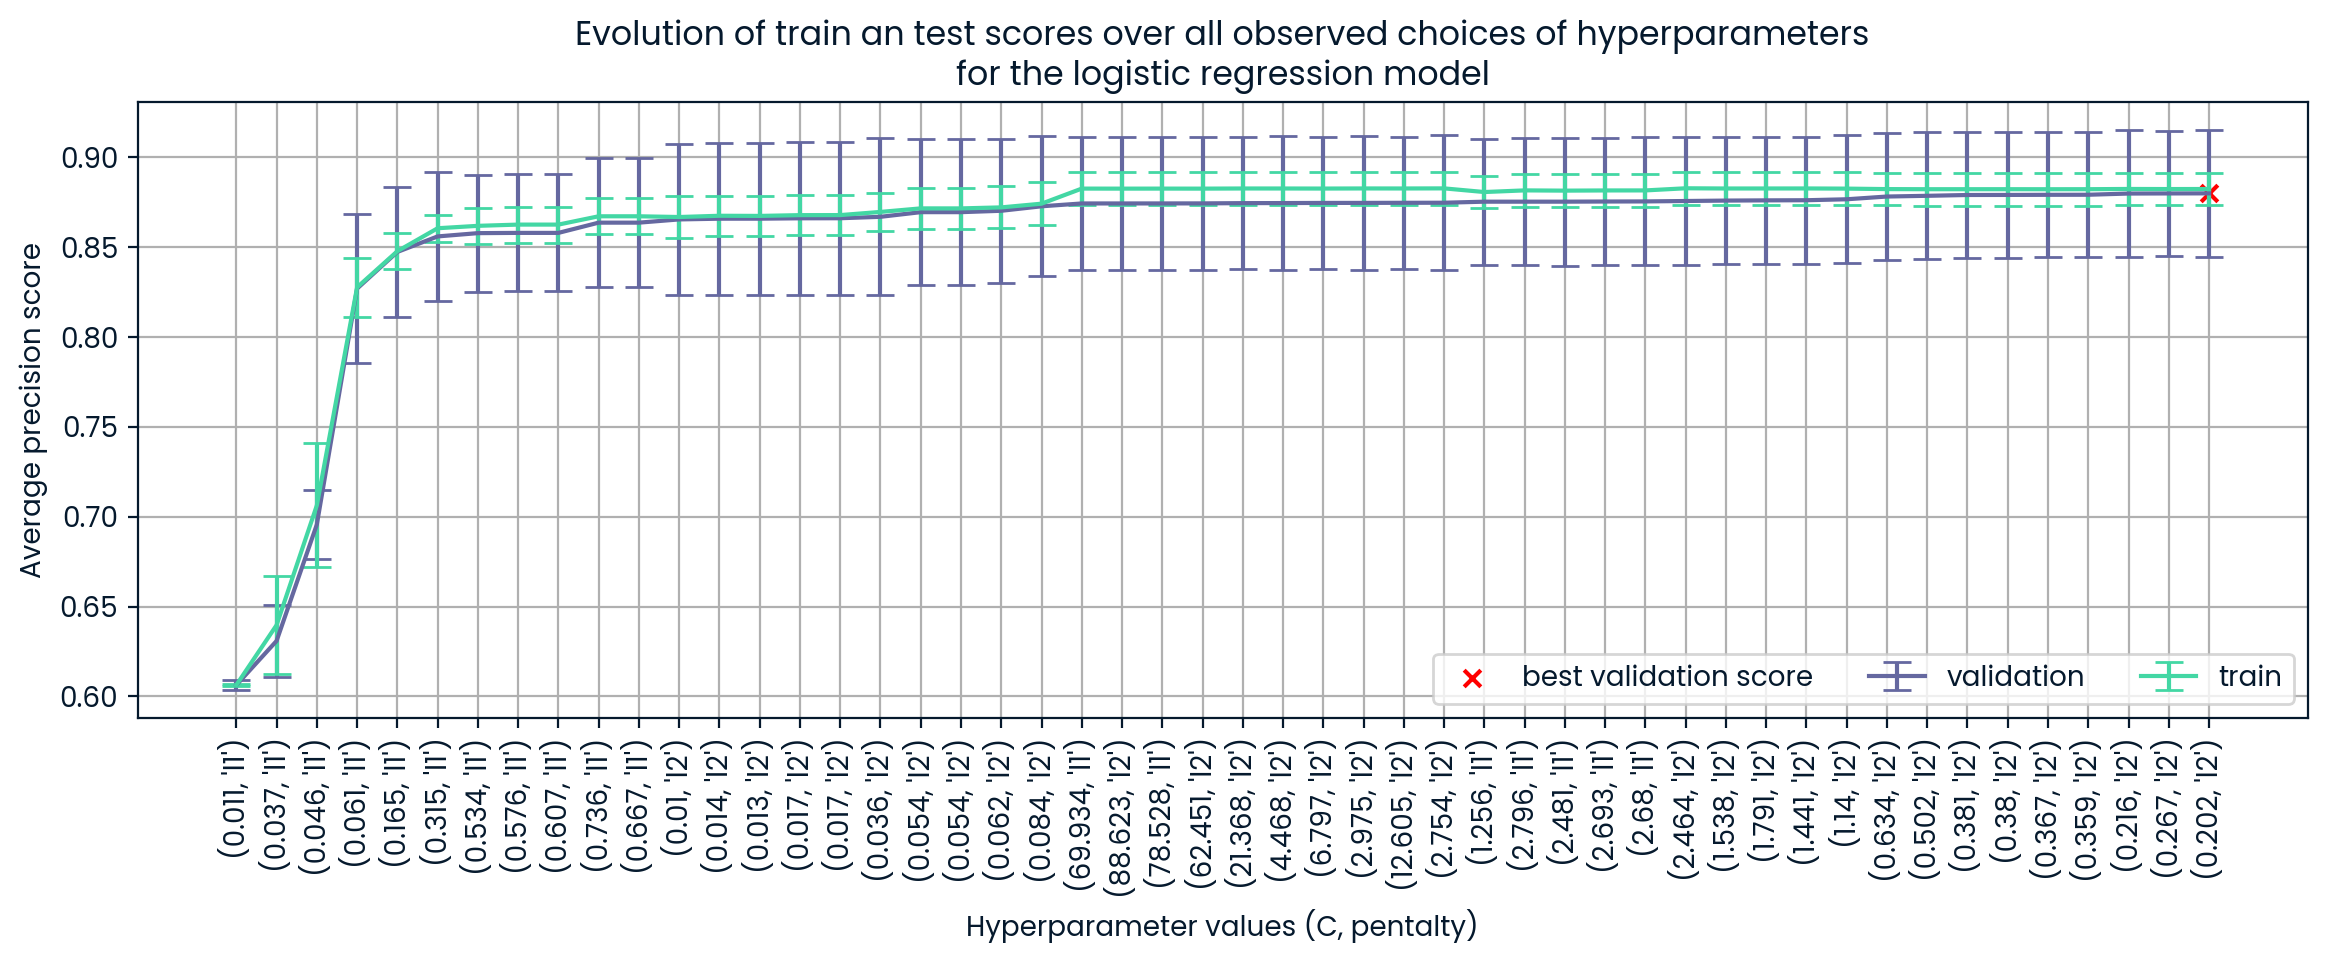

In [37]:
# Create a dataframe where each row corresponds to a specific choice of hyperparameter values and the 
# corresponding mean scores and their standard deviations for both training and test data
logreg_cv_results_df = pd.DataFrame({"C": [pardict["C"] for pardict in rcv_logreg.cv_results_["params"]],
                                     "penalty": [pardict["penalty"] for pardict in rcv_logreg.cv_results_["params"]],
                                     "mean_train_score": rcv_logreg.cv_results_["mean_train_score"],
                                     "std_train_score": rcv_logreg.cv_results_["std_train_score"],
                                     "mean_test_score": rcv_logreg.cv_results_["mean_test_score"],
                                     "std_test_score": rcv_logreg.cv_results_["std_test_score"]})

# Round value of the parameter "C" to 3 decimal places
logreg_cv_results_df["C"] = logreg_cv_results_df["C"].round(3)

# Sort values by mean test score in ascending order
logreg_cv_results_df = logreg_cv_results_df.sort_values(by="mean_test_score")

# Show evolution of mean train and test score over all hyperparameter value configurations 
# tested in the randomized search cross validation
fig, ax = plt.subplots(figsize=(14,4))
ax.grid(True)
# test score
ax.errorbar(range(len(logreg_cv_results_df)), 
            logreg_cv_results_df["mean_test_score"], 
            yerr=logreg_cv_results_df["std_test_score"],
            capsize=5, 
            label="validation")
# train score
ax.errorbar(range(len(logreg_cv_results_df)), 
            logreg_cv_results_df["mean_train_score"], 
            yerr=logreg_cv_results_df["std_train_score"],
            capsize=5,
            label="train")

# Add a marker at the location of the best validation score (at the far right of the plot)
ax.scatter(len(logreg_cv_results_df)-1, rcv_logreg.best_score_, marker="x", c="red", label="best validation score")
ax.set_xticks(range(len(logreg_cv_results_df)), zip(logreg_cv_results_df["C"], logreg_cv_results_df["penalty"]), rotation=90)
ax.set_xlabel("Hyperparameter values (C, pentalty)")
ax.set_ylabel("Average precision score")
ax.legend(loc="best", ncol=3)
ax.set_title("Evolution of train an test scores over all observed choices of hyperparameters\nfor the logistic regression model")
plt.show()

The figure above demonstrates that both the training and the validation precision scores are reasonably high and their values are quite close to each other, implying that the model is neither under- nor overfitting.

Next I compute the estimate for the performance of the classifier (i.e. its precision) on unseen data (the test set).

In [38]:
# Print test metrics
print(f"precision (test set): {(100*precision_score(y_test, y_pred_logreg)).round(2)}%")

precision (test set): 84.76%


This logistic regression classifier achieves a precision score of 84.76% on unseen data. In other words, out of all test examples predicted to generate high traffic on the web page, 84.76% are true positive (correct) predictions.

The product manager requested that high traffic recipes should be predicted correctly 80% of the time. **The baseline model satisfies this requirement.** Nonetheless I will create a comparison model.

### 3.3) KNN Classifier

As a comparison model I build a KNN classifier. This choice is motivated by two facts:

(1) KNN classifiers are quite intuitive to understand

(2) KNN, just like logistic regression, has relatively few hyperparameters and is hence nicely comparable to the baseline model

Again, in order to get a well-performing classifier, I tune the hyperparameters using a stratified 5-fold cross-validation approach. Just like in the logistic regression case, the test set created earlier is not involved in the training procedure at all.

In [39]:
# k-fold cross validation object (stratified because of class imbalance)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# classifier model
knn = KNeighborsClassifier()

# hyperparameters
np.random.seed(42)
knn_params = {"n_neighbors": list(set(np.random.randint(1,100, size=50))),
              "weights": ["uniform", "distance"]
            }

# randomized cross validation (CV) object to optimize hyperparameters
rcv_knn = RandomizedSearchCV(estimator=knn,
                            param_distributions=knn_params,
                            cv=kf,
                            n_jobs=-1,
                            n_iter=50,
                            return_train_score = True,
                            random_state=42,
                            scoring='average_precision')

# fit CV object
rcv_knn.fit(X_train, y_train)

# Extract best model measured by cross validation score
comparison_model = rcv_knn.best_estimator_

# Extract best model measured by cross validation score
print("Comparison model - hyperparameter tuning:")
print("=========================================")
print(f"Best validation score: {(100*rcv_knn.best_score_).round(2)}%")
print("Achieved with:", rcv_knn.best_params_)

# Use best model to make predictions on test set
y_pred_knn = comparison_model.predict(X_test)

Comparison model - hyperparameter tuning:
Best validation score: 87.87%
Achieved with: {'weights': 'distance', 'n_neighbors': 62}


I find a KNN model that achieves a validation precision score of 87.87%, which is marginally lower than the corresponding score of the logistic regression baseline. Again, I will now compare the training and the validation score in order to identify if I can learn whether or not the KNN model is over- or underfitting.

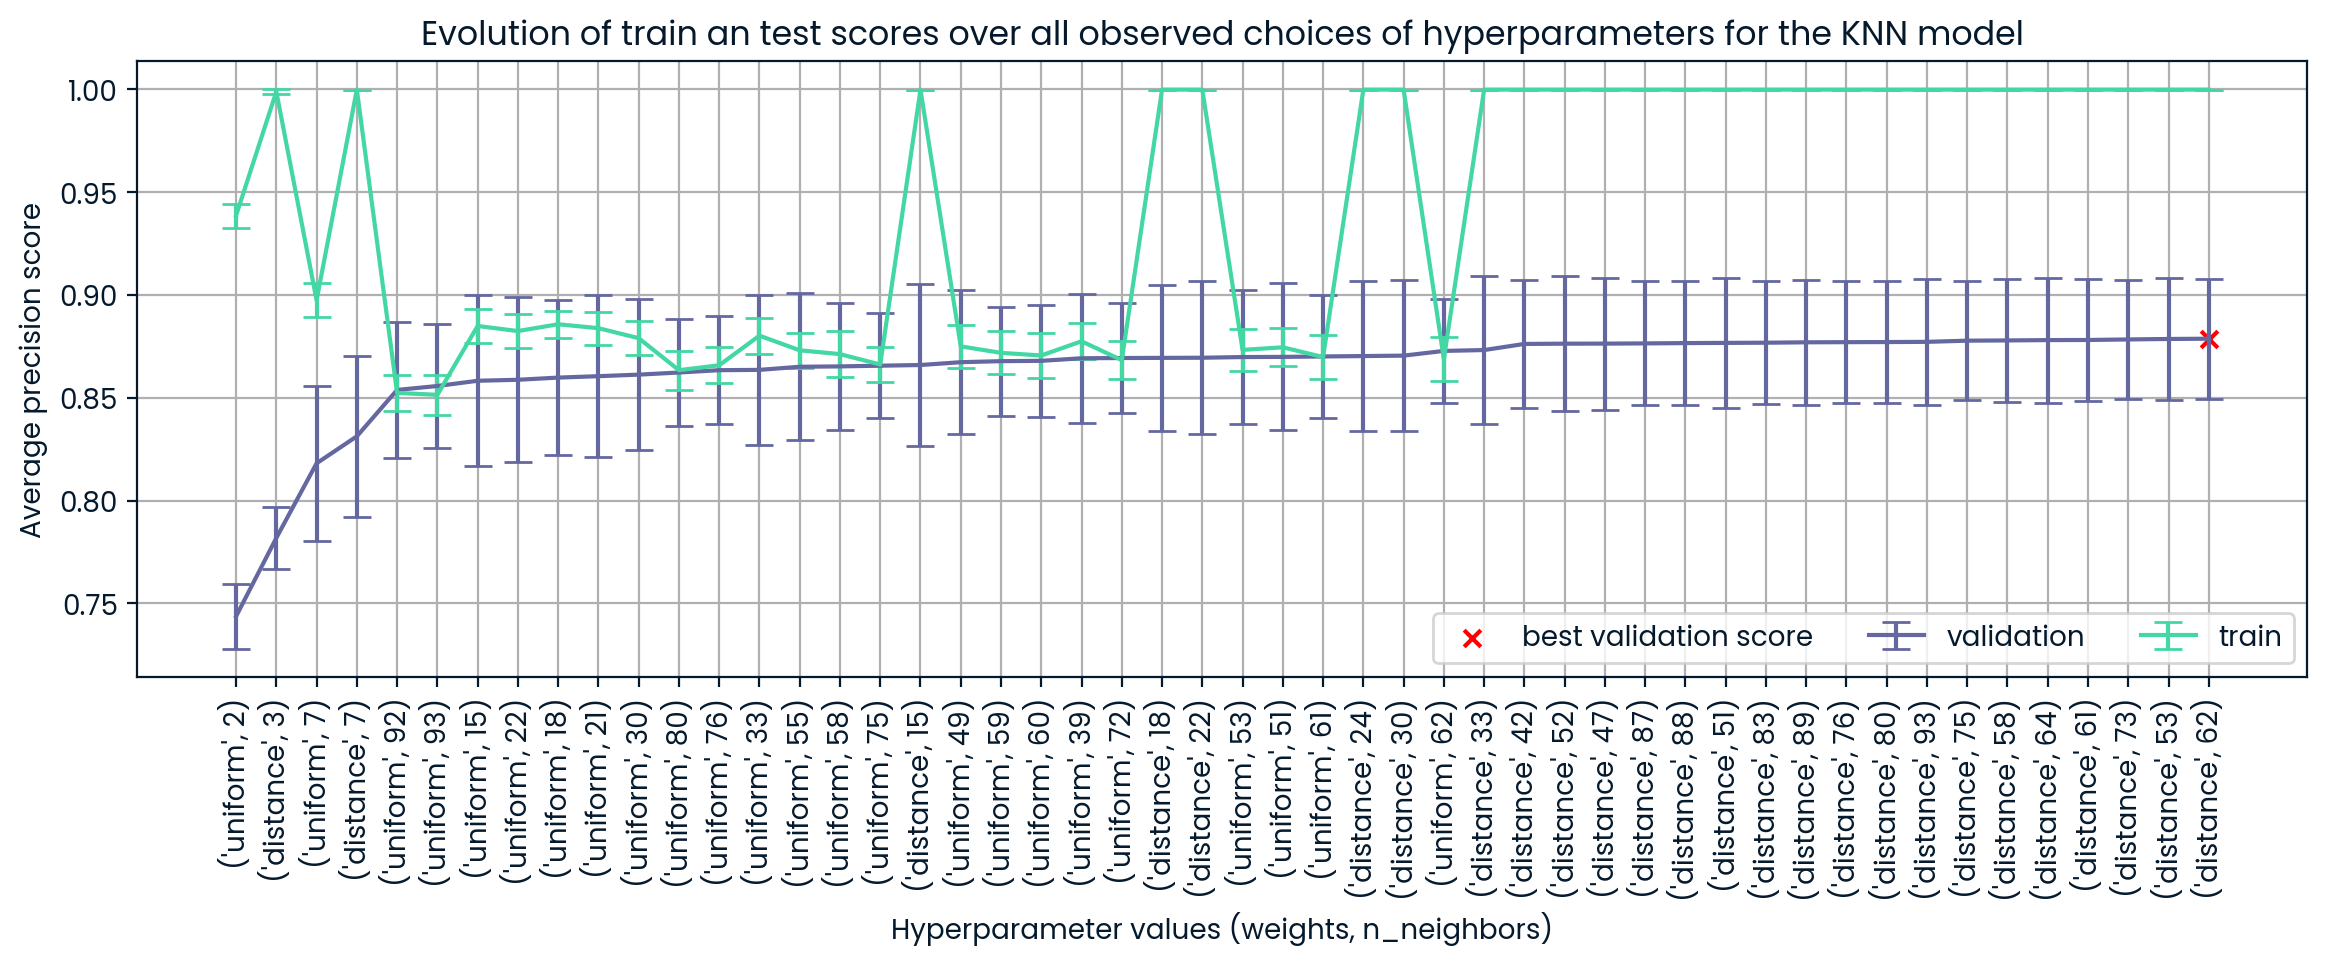

In [40]:
# Create a dataframe where each row corresponds to a specific choice of hyperparameter values and the 
# corresponding mean scores and their standard deviations for both training and test data
rcv_knn_results_df = pd.DataFrame({"weights": [pardict["weights"] for pardict in rcv_knn.cv_results_["params"]],
                                   "n_neighbors": [pardict["n_neighbors"] for pardict in rcv_knn.cv_results_["params"]],
                                   "mean_train_score": rcv_knn.cv_results_["mean_train_score"],
                                   "std_train_score": rcv_knn.cv_results_["std_train_score"],
                                   "mean_test_score": rcv_knn.cv_results_["mean_test_score"],
                                   "std_test_score": rcv_knn.cv_results_["std_test_score"]})

#rcv_knn_results_df.dropna(inplace=True)

# Sort values by mean test score in ascending order
rcv_knn_results_df = rcv_knn_results_df.sort_values(by="mean_test_score")

# Show evolution of mean train and test score over all hyperparameter value configurations 
# tested in the randomized search cross validation
fig, ax = plt.subplots(figsize=(14,4))
ax.grid(True)
# test score
ax.errorbar(range(len(rcv_knn_results_df)), 
            rcv_knn_results_df["mean_test_score"], 
            yerr=rcv_knn_results_df["std_test_score"],
            capsize=5, 
            label="validation")
# train score
ax.errorbar(range(len(rcv_knn_results_df)), 
            rcv_knn_results_df["mean_train_score"], 
            yerr=rcv_knn_results_df["std_train_score"],
            capsize=5,
            label="train")

# Add a marker at the location of the best validation score (at the far right of the plot)
ax.scatter(len(rcv_knn_results_df)-1, rcv_knn.best_score_, marker="x", c="red", label="best validation score")
ax.set_xticks(range(len(rcv_knn_results_df)), zip(rcv_knn_results_df["weights"],
                                                  rcv_knn_results_df["n_neighbors"]), rotation=90)
ax.set_xlabel("Hyperparameter values (weights, n_neighbors)")
ax.set_ylabel("Average precision score")
ax.legend(loc="best", ncol=3)
ax.set_title("Evolution of train an test scores over all observed choices of hyperparameters for the KNN model")
plt.show()

Notice that it is expected that the training precision score is always equal to 1 when the weights parameter is set to "distance". Thus the above figure needs to be interpreted slightly differently than the corresponding figure for the baseline model: the training precision score values carry basically no information when weights is set to "distance". Given that this is the situation for the best-performing hyperparameter value configuration(s) at the far right of the above graphic, I focus on the validation precision score: this value is quite high indicating that this comparison model performs well. However, the best found validation precision score is still very similar to the corresponding value of the baseline model.

Looking at the test precision score we find that the KNN algorithm achieves a marginally better value compared to the baseline model (85.44% vs 84.76%).

In [41]:
# Print test metrics
print(f"precision (test set): {(100*(precision_score(y_test, y_pred_knn))).round(2)}%")

precision (test set): 85.44%


Again, with a test precision score of 85.0% the KNN classifier exceeds the product manager's expectations to correctly classify high traffic recipes 80% of the time.

### 3.4) Deciding which model to choose
Given that the test precision of both the logistic regression and the KNN classifiers are both very similar, let's look at a different quantity to help decide which model to use in production. To do so I look at the recall, measuring how many popular (high traffic) recipes are incorrectly classified as low traffic or unpopular recipes, and the balanced accuracy measuring the fraction of overall correct predictions.

In [42]:
# Compare recall metrics
print(f"Logistic regression recall (test set): {(100*recall_score(y_test, y_pred_logreg)).round(2)}%")
print(f"KNN recall (test set): {(100*recall_score(y_test, y_pred_knn)).round(2)}%")

print(f"\nLogistic regression balanced accuracy (test set): {(100*balanced_accuracy_score(y_test, y_pred_logreg)).round(2)}%")
print(f"KNN balanced accuracy (test set): {(100*balanced_accuracy_score(y_test, y_pred_knn)).round(2)}%")

Logistic regression recall (test set): 77.39%
KNN recall (test set): 76.52%

Logistic regression balanced accuracy (test set): 78.03%
KNN balanced accuracy (test set): 78.26%


Both additional metrics deviate by less than 1% between the models indicating that both models are essentially equivalent regarding their performance on unseen data.

### Conclusion
I have trained a logistic regression and a KNN classifier to predict whether or not a recipy will generate high traffic on the "Tasty Bytes" webpage. Both models achieve a precision score/KPI value >80%, satisfying the project manager's request. In addition, they also perform almost identically in other KPIs such as the number of popular recipes incorrectly classified as unpopular ("recall").

Given that the two models perform essentially equally well, I choose the logistic regression model over the KNN classifier going forward because the logistic regression model not only performs well but also lets us analyze feature importances quiet conveniently. Therefore, with the logistic regression model we can not only perform accuracte predictions of the high traffic recipes but also extract useful business insights. This is what I am going to do next.

## 4) Business relevant learnings

The logistic regression model lets us extract business relevant intelligence from the model by analyzing which features are important for the model.

In [43]:
# Extract (signed) feature importances
feature_importances = pd.DataFrame(base_line_model.coef_.transpose(), 
                                   index = X_train.columns, 
                                   columns=["feature_importance"]).sort_values("feature_importance")
feature_importances

,feature_importance
category_Beverages,-1.894572
category_Breakfast,-1.065583
category_Chicken,-0.804035
sugar,-0.221945
category_Lunch/Snacks,-0.028982
category_Dessert,-0.018468
protein,0.137554
carbohydrate,0.147300
calories,0.201282
category_Meat,0.311967


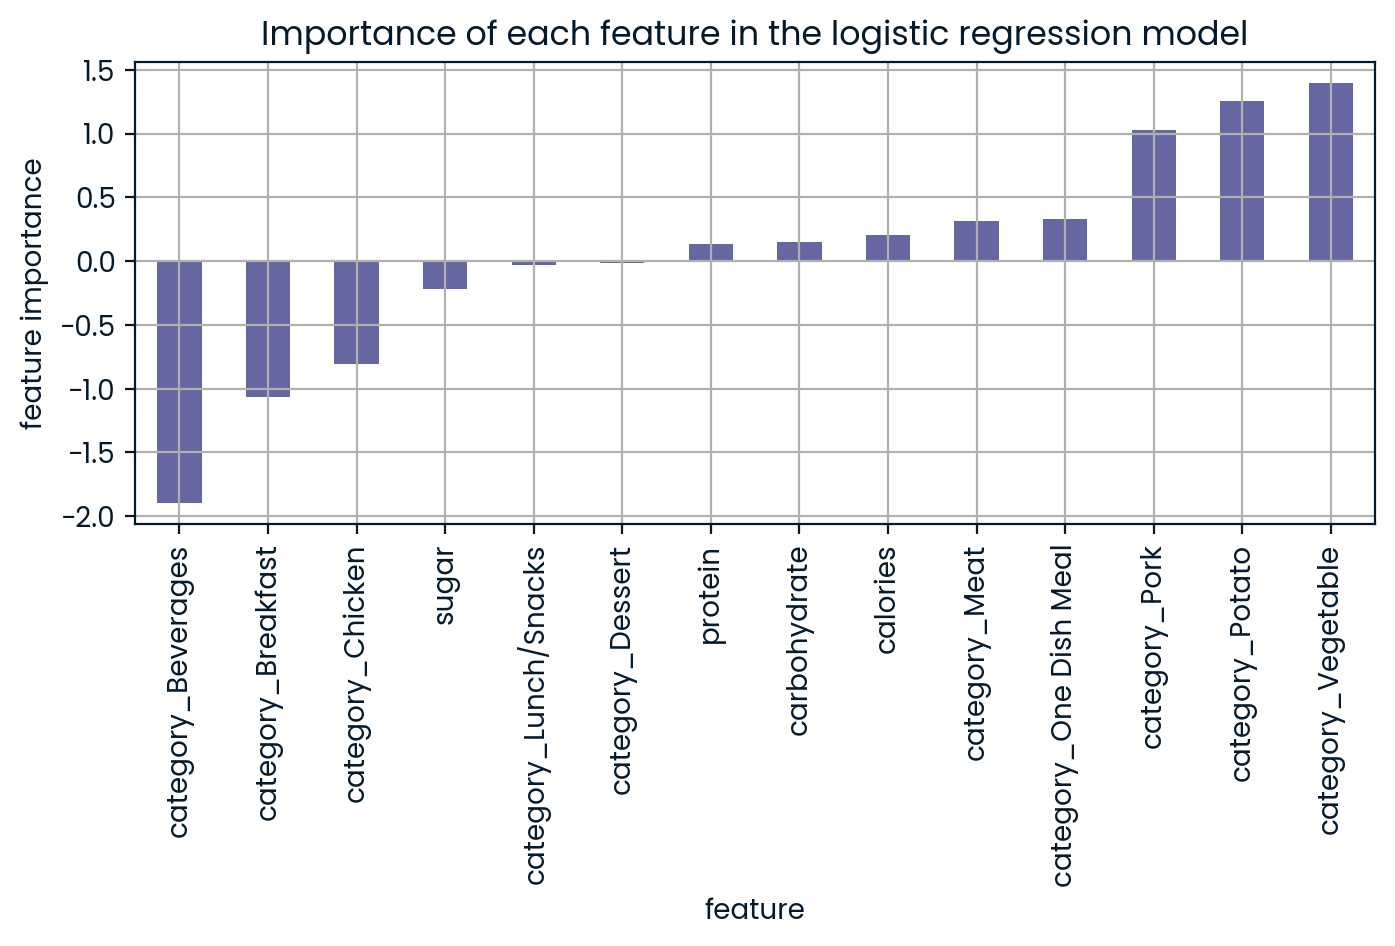

In [44]:
# Plot (signed) feature importances from logistic regression model
fig, ax = plt.subplots(figsize=(8,3))
feature_importances.plot(kind="bar", grid=True, ax=ax, legend=False)
ax.set_xlabel("feature")
ax.set_ylabel("feature importance")
ax.set_title("Importance of each feature in the logistic regression model")
plt.show()

Analyzing the signed feature importances one can clearly confirm the fact observed already earlier in the visual data analysis (subsection 2.3.2): the features most drastically impacting the popularity of a recipy (and therefore the traffic on the web page) are

- whether or not a recipy is for a beverage ("category_Beverages")
- whether or not a recipy involves vegetables ("category_Vegetable")
- whether or not a recipy involves potato ("category_Potato")

From the fact that the feature importance value of "category_Beverages" is negative one can infer that recipes for beverages are particularly unpopular (i.e. drive traffic down). "Tasty Bytes" should obviously avoid displaying recipes for beverages on their webpage in the future.

## 5) Summary and Recommendations

The project manager of the company "Tasty Bytes" requested a automated, data-driven classifier (machine learning model) to correctly classify which recipes are popular and which are not. They observed that displaying popular recipes on their webpage tends to increase the overall traffic on their webpage which leads to more subscriptions for their services and products. The request was specifically to come up with a model that correctly classifies high traffic-generating recipes 80% of the time.

The project manager provided me with a data set about meta information about recipies and indicated which of them generated high traffic. I cleaned, validated and investigated this data set. I observed no correlations between the independent variables and extracted preliminary findings about which recipe categories tend to be more popular than others.

I trained a logistic regression classifier as a baseline model and a KNN classifier for comparison. I optimized the hyperparameters for both of them using 5-fold, stratified, randomized cross validation. Both models achieve almost identical KPI performance on unseen data: with precision scores of 84.76% and 85.44%, respectively, both models exceed the stated requirement of correctly classifying high traffic recipes 80% of the time. 

Even on additional KPIs such as the amount of popular recipes incorrectly classified as unpopular (recall) and the overall classification accuracy deviated by less than 1% from each other. Both classifier models are thus nearly identical regarding their KPI performance on unseen data.

An indepth analysis of the signed feature importances demonstrated that beverages are significantly unpopular while recipes with vegetables, potatos and pork are popular.

**Recommandations:** To the project manager of "Tasty Bytes" I recommend to use the logistic regression classifier to automatically classify which recipes to display on their webpage. When looking into new recipes, they should focus on recipes with vegetables, potatos and pork while recipes for beverages should be avoided. 

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation